In [6]:
import copy
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5
 
# our observation noise
R = 20 * np.eye( 2 )
 
# initial state
mu_t = np.zeros(( 6, 1 ))
sigma_t = np.eye( 6 )

def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

def kalman(data, mu_t, Q, R, sigma_t, mus, covs):
    estimated = np.zeros(data.shape)

    for i in range(len(data)):
        y_t = data[i].reshape((2,1))
        mu_b = mu_t
        sigma_b = sigma_t
           
        # calc new mean
        sig_prime = np.dot(np.dot(A, sigma_b), A.T) + Q
        S_t = np.dot(np.dot(C, sig_prime), C.T) + R
        K_t = np.dot(np.dot(sig_prime, C.T), np.linalg.pinv(S_t))
        y_hat = np.dot(np.dot(C, A), mu_b)
        mu_t = np.dot(A, mu_b) + np.dot(K_t, (y_t - y_hat))
        
        # calc new covariance
        sigma_t = np.dot((np.eye(6) - np.dot(K_t, C)), sig_prime)
        estimated[i] = np.dot(C, mu_t).reshape(2)
        
        mus.append(estimated[i])
        covs.append(sigma_t)
    
    return estimated

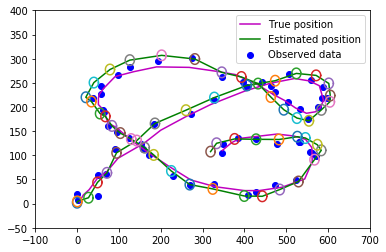

In [7]:
kfmat = loadmat('kfdata.mat')
data = kfmat['data']
true_data = kfmat['true_data']
estimated = kalman(data, mu_t, Q, R, sigma_t, [], [])

ax = plt.subplot()
ax.scatter(data[:,0], data[:, 1], color='b', label='Observed data')
ax.plot(true_data[:,0], true_data[:,1], color='m', label='True position')
ax.plot(estimated[:,0], estimated[:,1], color='g', label='Estimated position')
pts = cov_to_pts(R)
for pt in estimated:
    ax.plot(pts[0]+pt[0], pts[1]+pt[1])
plt.xlim(-100, 700)
plt.ylim(-50, 400)
plt.legend()
plt.show()

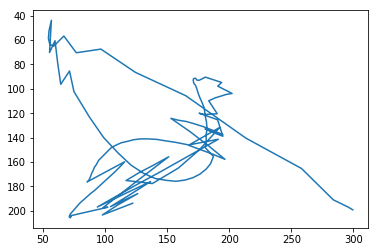

In [8]:
import scipy.io
import skimage.feature
import matplotlib

tmp = scipy.io.loadmat('ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template
 
data = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results
 
data = np.asarray( data )
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-6 * np.eye( 6 )
Q[4,4] = 0.005  # variance of accelerations is higher
Q[5,5] = 0.005
 
# our observation noise
R = 5e2 * np.eye( 2 )

# initial state
mu_t = np.zeros(( 6, 1 ))
mu_t[0] = 300
mu_t[1] = 200
sigma_t = np.eye( 6 )
mus = []
covs = []
estimated = kalman(data, mu_t, Q, R, sigma_t, mus, covs)
plt.plot([mu[0] for mu in mus], [mu[1] for mu in mus])
plt.gca().invert_yaxis()
plt.show()

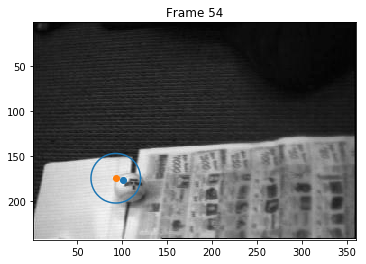

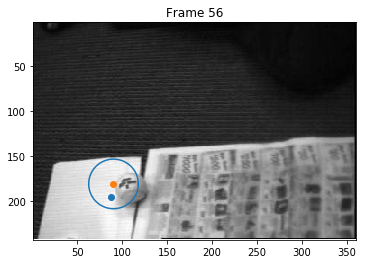

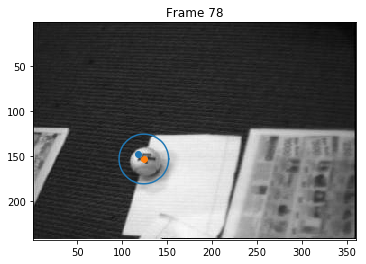

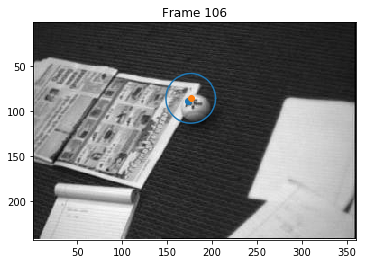

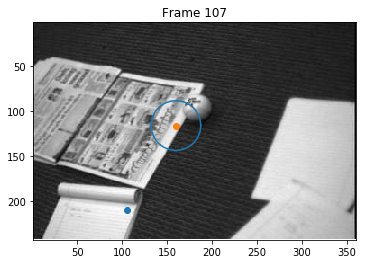

In [ ]:
for t in [54, 56, 78, 106, 107]:
    tmp = np.reshape( frames[:,t], (360,243) ).T
    plt.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
    plt.scatter( data[t][1], data[t][0] )
    plt.scatter( mus[t][1], mus[t][0] )
 
    foo = cov_to_pts( covs[t][0:2,0:2] )
 
    plt.plot( foo[0,:] + mus[t][1], foo[1,:] + mus[t][0] )
    plt.xlim([1, 360])
    plt.ylim([243,1])
    plt.title('Frame %d' % t) 
    plt.show()

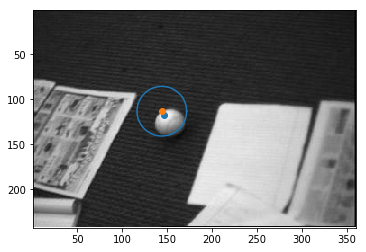

In [ ]:
# assumes that "mus" contains a list of Gaussian means, and that "covs" is a list of Gaussian covariances
# also assumes you are running in Jupyter Notebook
 
from IPython.display import clear_output
 
 
for t in range(0, data.shape[0]):
 
    tmp = np.reshape( frames[:,t], (360,243) ).T
 
    plt.figure(1)
    plt.clf()
    plt.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
    plt.scatter( data[t][1], data[t][0] )
    plt.scatter( mus[t][1], mus[t][0] )
 
    foo = cov_to_pts( covs[t][0:2,0:2] )
 
    plt.plot( foo[0,:] + mus[t][1], foo[1,:] + mus[t][0] )
    plt.xlim([1, 360])
    plt.ylim([243,1])
    clear_output(wait = True)
 
    plt.pause(0.01)

I chose R for the covariance plot size (about double the ball size), Q for the amount the mean resists outlier measurements, and initial mu and sigma to match initial ball position.